In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
def plot_spectrum(F_shift, title):
    """Plot the magnitude spectrum of a Fourier transformed image"""
    magnitude_spectrum = 20 * np.log(np.abs(F_shift) + 1)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.colorbar()

In [3]:
def apply_fourier_transform(image):
    """Apply Fourier Transform to an image"""
    # Convert to grayscale if needed
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply Fast Fourier Transform
    f = np.fft.fft2(gray)
    # Shift the zero frequency component to the center
    f_shift = np.fft.fftshift(f)

    return f_shift, gray

In [4]:
def apply_inverse_fourier_transform(f_shift):
    """Apply Inverse Fourier Transform"""
    # Shift back
    f_ishift = np.fft.ifftshift(f_shift)
    # Inverse FFT
    img_back = np.fft.ifft2(f_ishift)
    # Take the absolute value and convert to uint8
    img_back = np.abs(img_back).astype(np.uint8)

    return img_back

In [5]:
def low_pass_filter(f_shift, radius):
    """Apply a low pass filter (keeps low frequencies)"""
    rows, cols = f_shift.shape
    crow, ccol = rows // 2, cols // 2

    # Create a mask with a circle in the center
    mask = np.zeros((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius * radius
    mask[mask_area] = 1

    # Apply mask
    f_shift_filtered = f_shift * mask

    return f_shift_filtered, mask

In [6]:
def high_pass_filter(f_shift, radius):
    """Apply a high pass filter (keeps high frequencies)"""
    rows, cols = f_shift.shape
    crow, ccol = rows // 2, cols // 2

    # Create a mask with a circle in the center (inverted from low pass)
    mask = np.ones((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius * radius
    mask[mask_area] = 0

    # Apply mask
    f_shift_filtered = f_shift * mask

    return f_shift_filtered, mask


In [7]:
def band_pass_filter(f_shift, inner_radius, outer_radius):
    """Apply a band pass filter (keeps frequencies between inner and outer radius)"""
    rows, cols = f_shift.shape
    crow, ccol = rows // 2, cols // 2

    # Create a mask with a ring
    mask = np.zeros((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]

    # Define the ring
    mask_area = np.logical_and(
        (x - center[0]) ** 2 + (y - center[1]) ** 2 >= inner_radius ** 2,
        (x - center[0]) ** 2 + (y - center[1]) ** 2 <= outer_radius ** 2
    )
    mask[mask_area] = 1

    # Apply mask
    f_shift_filtered = f_shift * mask

    return f_shift_filtered, mask


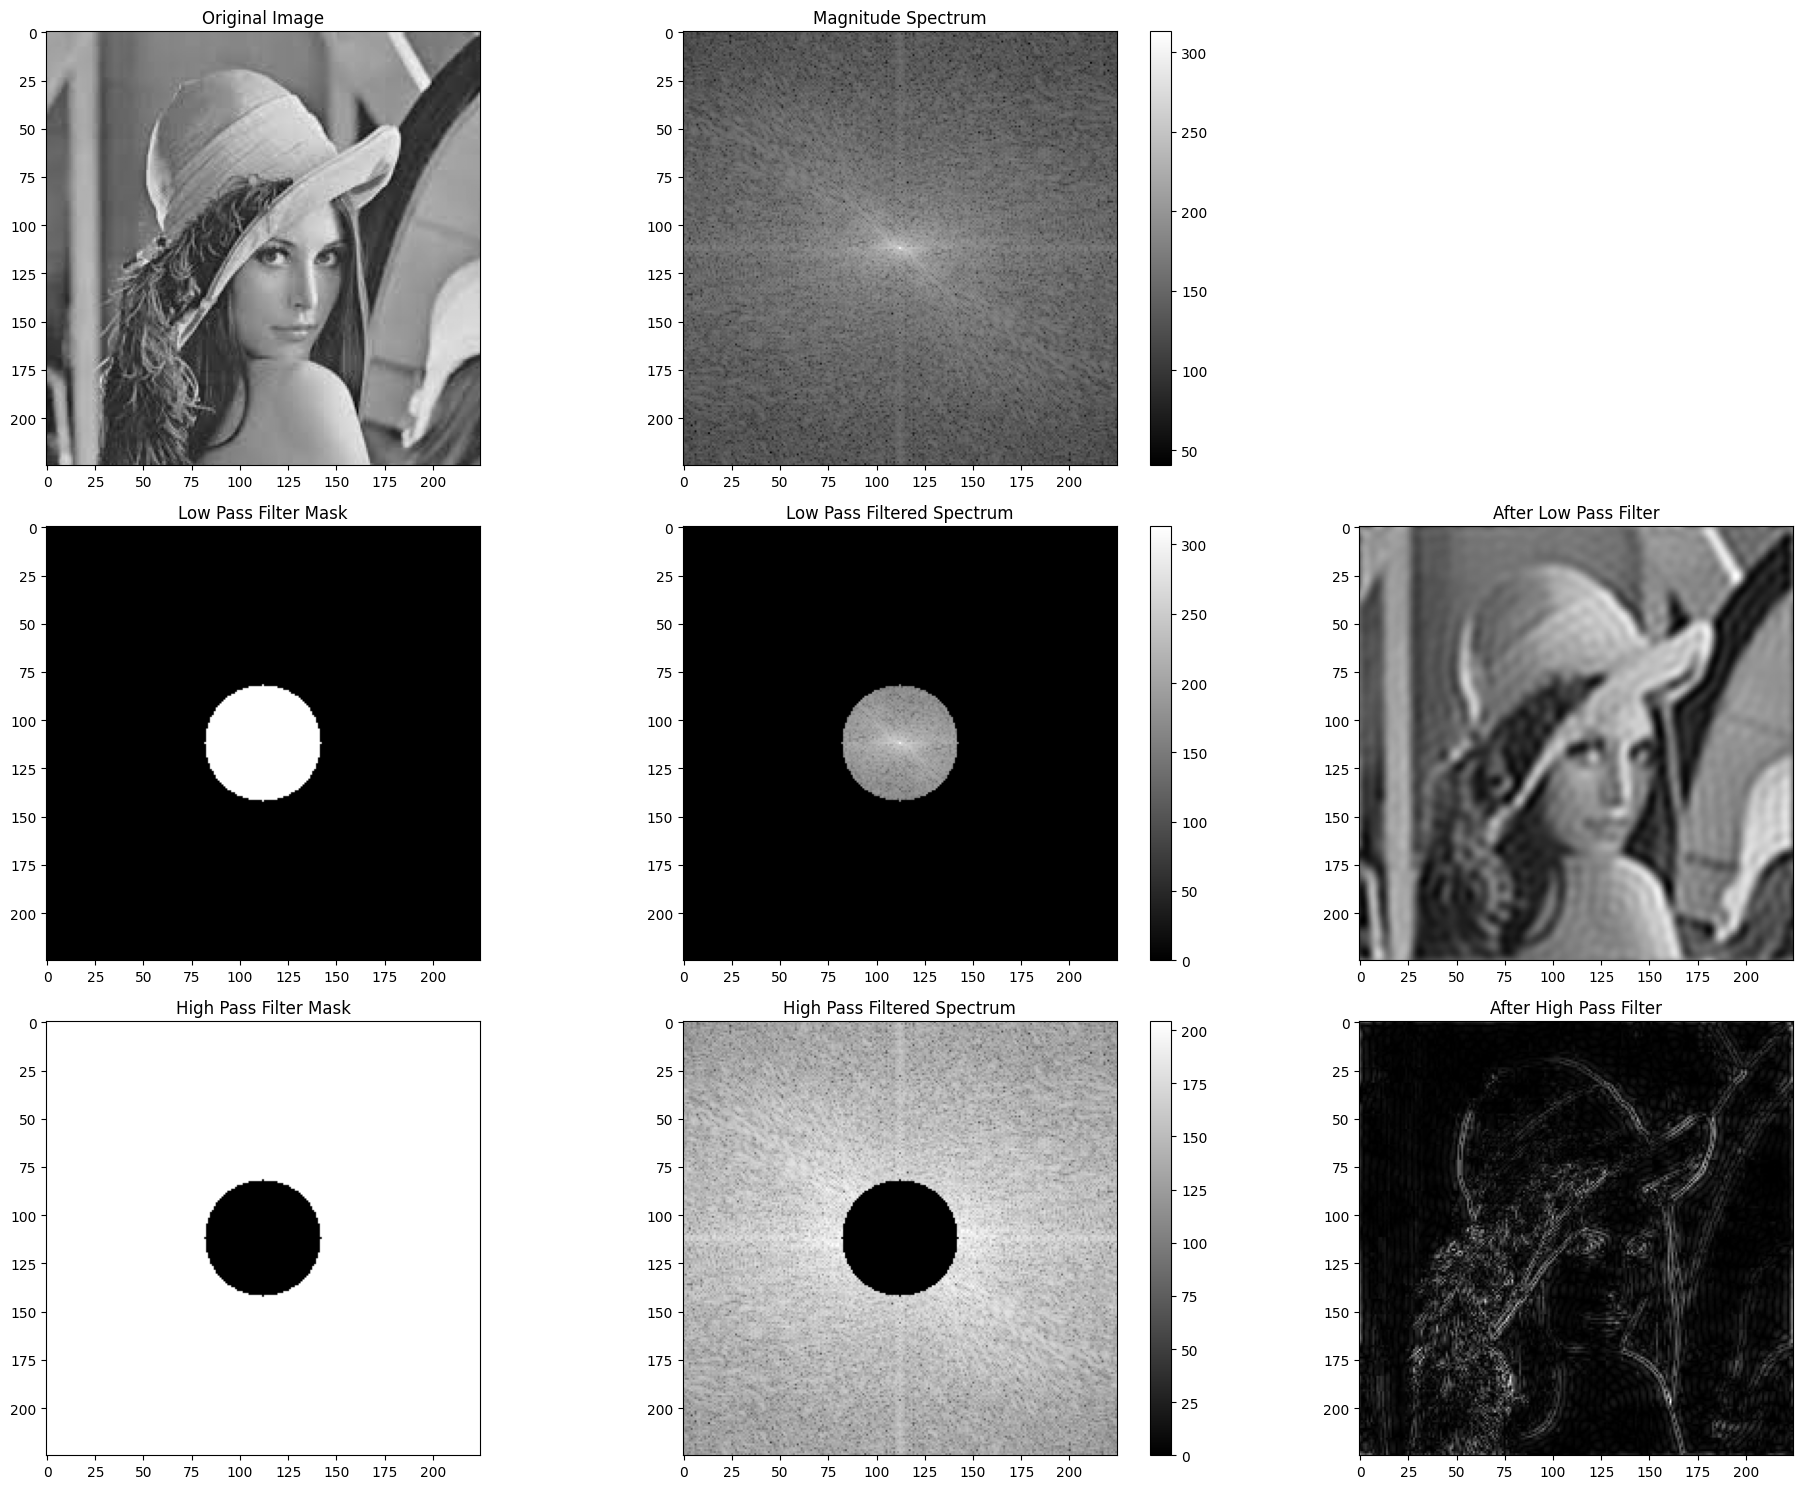

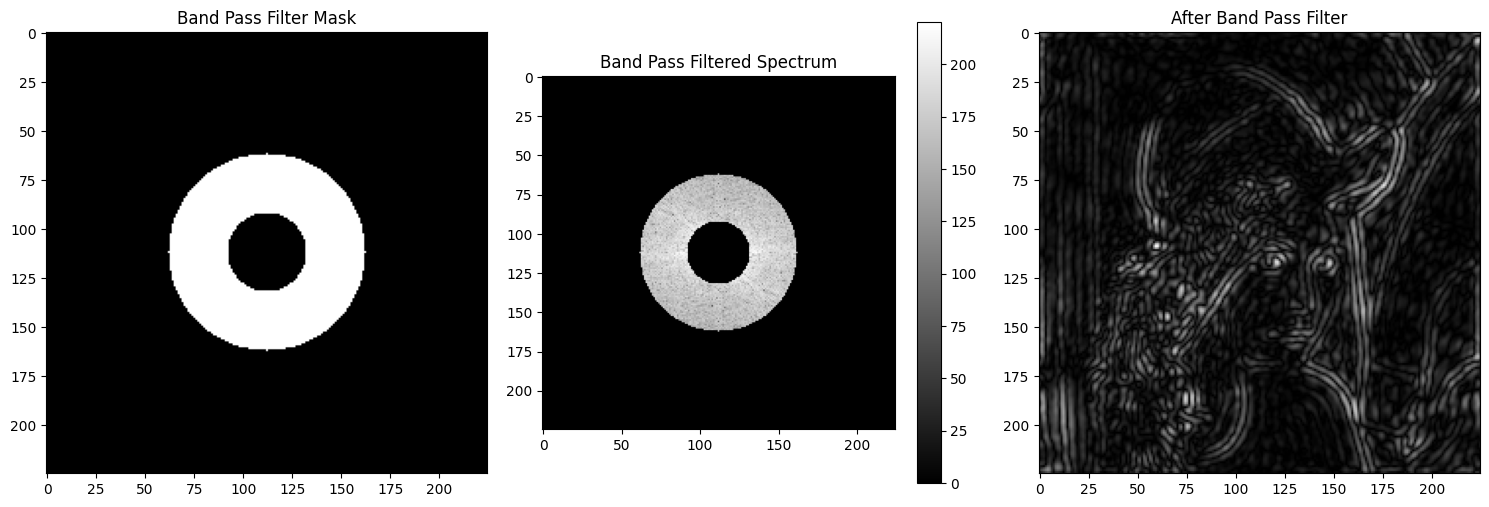

Processing complete!


In [8]:
def main():
    # Load an image (replace with your own image path)
    image = cv2.imread('/content/download.jpeg')

    if image is None:
        # If no image is available, create a test pattern
        print("No image found, creating test pattern...")
        image = np.zeros((512, 512), dtype=np.uint8)
        cv2.circle(image, (256, 256), 100, 255, -1)
        cv2.rectangle(image, (100, 100), (200, 200), 255, -1)

    # Step 1: Apply Fourier Transform
    f_shift, gray = apply_fourier_transform(image)

    # Step 2: Apply different filters
    # Low-pass filter (keeps low frequencies)
    f_shift_low, mask_low = low_pass_filter(f_shift.copy(), radius=30)

    # High-pass filter (keeps high frequencies)
    f_shift_high, mask_high = high_pass_filter(f_shift.copy(), radius=30)

    # Band-pass filter (keeps frequencies between inner and outer radius)
    f_shift_band, mask_band = band_pass_filter(f_shift.copy(), inner_radius=20, outer_radius=50)

    # Step 3: Apply Inverse Fourier Transform to each filtered image
    img_low = apply_inverse_fourier_transform(f_shift_low)
    img_high = apply_inverse_fourier_transform(f_shift_high)
    img_band = apply_inverse_fourier_transform(f_shift_band)

    # Display results
    plt.figure(figsize=(20, 15))

    # Original image
    plt.subplot(3, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Image')

    # Fourier spectrum
    plt.subplot(3, 3, 2)
    plot_spectrum(f_shift, 'Magnitude Spectrum')

    # Low-pass filter
    plt.subplot(3, 3, 4)
    plt.imshow(mask_low, cmap='gray')
    plt.title('Low Pass Filter Mask')

    plt.subplot(3, 3, 5)
    plot_spectrum(f_shift_low, 'Low Pass Filtered Spectrum')

    plt.subplot(3, 3, 6)
    plt.imshow(img_low, cmap='gray')
    plt.title('After Low Pass Filter')

    # High-pass filter
    plt.subplot(3, 3, 7)
    plt.imshow(mask_high, cmap='gray')
    plt.title('High Pass Filter Mask')

    plt.subplot(3, 3, 8)
    plot_spectrum(f_shift_high, 'High Pass Filtered Spectrum')

    plt.subplot(3, 3, 9)
    plt.imshow(img_high, cmap='gray')
    plt.title('After High Pass Filter')

    plt.tight_layout()
    plt.savefig('fourier_results_1.png')

    # Second figure for band-pass filter
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(mask_band, cmap='gray')
    plt.title('Band Pass Filter Mask')

    plt.subplot(1, 3, 2)
    plot_spectrum(f_shift_band, 'Band Pass Filtered Spectrum')

    plt.subplot(1, 3, 3)
    plt.imshow(img_band, cmap='gray')
    plt.title('After Band Pass Filter')

    plt.tight_layout()
    plt.savefig('fourier_results_2.png')

    plt.show()

    print("Processing complete!")

if __name__ == "__main__":
    main()